---
title: "PIC16B HW3: Web Development"
author: "Zhe Shen"
date: "2023-2-17"
categories: [PIC16B HW]

---

# PIC16B HW3: Web Development

In this blog, I describe how to develop a web page via **Flask** that can receive user input and store the input in a **message bank** in a **SQL** database. In addition this web page is able to provide the function of 3 random messages.To accomplish this task we need to master the following skills：
- Flask fundamentals, including **render_template()**, the basic anatomy of templates, and user interactions.
- Database skills, including adding items to databases and displaying them.
- Basic CSS in order to add a bit of personal flare to your webapp.

You can access the git repository for this project via [this link](https://github.com/ZheShen00/PIC16B-HW3).

# 1.Web templates programing 
First we need to build a frame for the page. This step can be done by programming in Notepad to build it. In this blog, we will create some html files：
- **base.html**: The home page of the web page and will guide users.
- **submit.html**: Based on base.html, which will be used to collect user input.
- **view.html**: Based on base.html, which will be used to provide the message history.

## Part 1：Base.html
Here is the basic structure of **base.html**, which I drew heavily from the file we used in class. Anyone can use this as a template to modify and create their own **.html** files.After obtaining the base.html file, we will discuss the process of creating the **submit.html** and **view.html** files. These two files will be an important part of completing the functionality of our web page.

<!doctype html>

<link rel="stylesheet" href="{{ url_for('static', filename='style.css') }}">
<title>{% block title %}{% endblock %} - Message Bank</title>
<nav>
   <h1>Message Bank</h1>
	<!-- <b>Navigation:</b> -->
  	<ul>
		<li><a href="{{ url_for('submit') }}">Submit a message</a></li>
		<li><a href="{{ url_for('view')}}">View messages</a></li>
	</ul>
</nav>
<section class="content">
	<header>
		{% block header %} Welcome to the Message Bank!{% endblock %}
 </header>
 {% block content %}
 	<p>Please feel free to leave a message along with your name or handle.</p>
 	<p>Or you can check 3 random messages in Message Bank by clicking the button of View messages </p>
 	{% endblock %}
</section>

## Part 2：submit.html
The following content is the main code of the **base.html** file. We will build two text boxes to collect the message and name entered by the user. The input process will be executed by clicking the submit button. At the end of the submit process we will return a message to enhance the user experience.

The notable part of the code is the **{%block content%}** section, which will provide the text box we described above. This section will provide the text box we described above, where **label for=** will help us provide input prompts, and **input type=** will to ensure that your submit.html template creates these fields from user input by appropriately specifying the name of the input elements. Finally, **< input type = " submit " >** will create a submit button.

{% extends 'base.html' %}

{% block header %}
  <h1>{% block title %}Submit{% endblock %}</h1>
{% endblock %}

{% block content %}
  <form method="post">
      <label for="message">Please leave a message:</label><br>
      <input type="text" name="message" id="message"> <br>
      <label for="handle">Your name or handle:</label><br>
      <input type="text" name="handle" id="handle"> <br>
      <input type="submit" value="Submit message">
  </form>

  {% if epilogue %}
     <br> 
     Thank for your submission, {{handle}}! Your message is under below: <br>
     {{message}}
  {% endif %}

{% endblock %}

## Part 3：view.html
The following is the main code of the **view.html** file. This function does not require much human interaction so the content is relatively simple. We just need to construct the layout of the page and the text content. The function to assign three random messages will be implemented in the next step by creating a **randoom_messages** function.

{% extends 'base.html' %}

{% block header %}
  <h1>{% block title %}messages history{% endblock %}</h1>
{% endblock %}

{% block content %}
  <ul>
      {% for m in messages %}
      <p> {{m[2]}} </p> 
      <p> -- {{m[1]}} </p> <br>
      {% endfor %}
  </ul>


{% endblock %}

# 2.The part of  app.py programing 
Now, we will write a py file for database management, which includes：
- **get_message_db()**: This function will handle the creation of the message database and complete the following algorithmic process:

    * Check whether there is a database called **message_db** in the g attribute of the app. If not, then connect to that database, ensuring that the connection is an attribute of g.
    * Check whether a table called **messages** exists in **message_db**, and create it if not.
    * Return the connection **g.message_db**.
- **insert_message(request)**：This function will handle inserting a user message into the database of messages and complete the following algorithmic process:
    * Extract the **message** and the **handle** from **request**.
    * Using a **cursor**, insert the message into the **message** database. (We need to provide an ID number, the handle, and the message itself. A SQL command to perform the insertion would be helpful.)

PS: Don't forget to close the connection.

In [7]:
def get_message_db():
    '''
    Check is there exits a table named messages in message_db or not.
    If there is a database called message_db in the g attribute of the app,using the try except command to test .
    If there is, just return the database. 
    if there is not, go to the except.
    '''
    
    
    try:
        return g.message_db
    
    
    # If there is no database in g, we need connect one in the attribute g
    except:
        g.message_db = sqlite3.connect("messages_db.sqlite")
        
        
        # Using SQL command to check if there is a table named messages in messages_db.
        # If there is no table exit, just create one with three columns: id, handle, and message.
        cmd = """CREATE TABLE IF NOT EXISTS messages (
                id INTEGER PRIMARY KEY,
                handle TEXT,
                message TEXT)"""
        cursor = g.message_db.cursor()
        cursor.execute(cmd)
        return g.message_db

In [9]:
def insert_message(request):
    
    # Extracting message and handle.
    message = request.form['message']
    handle = request.form['handle']
    
    # Call get_message_db() to connect to the database.
    db = get_message_db()
    
    # Creating a cursor object.
    cursor = db.cursor()
    
    # Finding current number of row of the table. 
    cursor.execute("SELECT COUNT(*) FROM messages")
    id_num = cursor.fetchone()[0] + 1
    
    # Insert id, message, and handle into the table.
    cursor.execute("INSERT INTO messages (id, handle, message) VALUES (?, ?, ?)", (id_num, handle, message))
    db.commit()
    
    # Close the connection
    db.close()
    
    return message, handle

### random_messsages(n)
In addition, as I mentioned above, we need to write a **random_messsages(n)** function to return 3 random messages. we will first connect to the database and get a **cursor object**. It's worth noting that at the end, don't forget to close the connection and return the messages.

In [10]:
def random_messages(n):
    
    # Call get_message_db() to connect to the database.
    db = get_message_db()
    
    # Creating a cursor object.
    cursor = db.cursor()
    
    # Choosing n random messages from the table.
    cursor.execute("SELECT * FROM messages ORDER BY RANDOM() LIMIT ?",(n,))
    
    # Output all the messages.
    messages = cursor.fetchall()
    
    # close the connection.
    db.close()
    
    return messages

### Additional function (base(), submit()& view())
To render a template
In this section, we need to render our programming effects from the previous section to the relevant html files：
- **base()**: render the template of **base.html**.
- **submit()**: Rendering is done by supporting **POST** and **GET** methods：
    * If the user just visits the link, then **request.method** will be **GET** and render **submit.html** directly to the user. 
    * If the user tries to enter a message, we call **insert_message(request)** to store the input message and then render it to **submit.html**. 
- **view()**: we will call **random_messages()** to output three random messages and save them in the **.html** file. Then the messages will be served to the user by rendering the **.html** file.

In [ ]:
@app.route('/')
def base():
    return render_template('base.html')



@app.route('/submit/', methods=['POST', 'GET'])
def submit():
    if request.method == 'GET':
        return render_template('submit.html')
    else:
        message, handle = insert_message(request)
        return render_template('submit.html', epilogue = True, message = message, handle = handle)



@app.route('/view/')
def view():
    messages = random_messages(3)
    return render_template('view.html', messages = messages)

# Screenshot of the actual result
We can change style of the word and background in **CSS** file as follows:

In [ ]:
html {
    font-family: Roboto Light;
    background: #237597 ;
    padding: 1rem;
}

body {
    max-width: 900px;
    margin: 0 auto;
}

h1 {
    color: rgb(0, 0, 0);
    font-family: Roboto Light;
    margin: 1rem 0;
    text-align: center;
}

a {
    color: #196F3D;
    text-decoration: none;
}

![user_input%20%282%29%20(1).png](attachment:user_input%20%282%29%20(1).png)
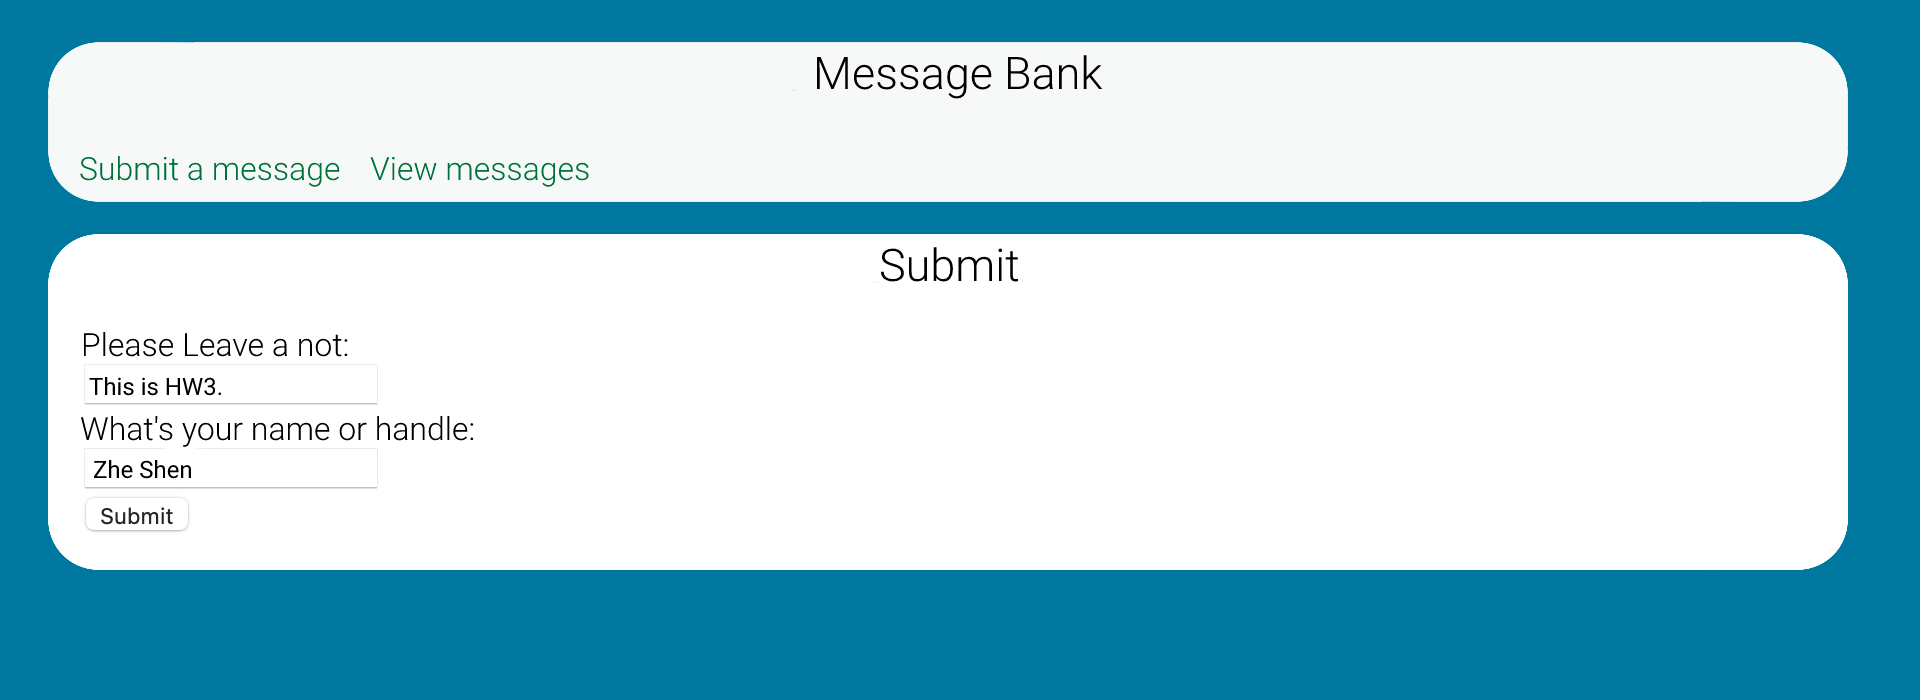

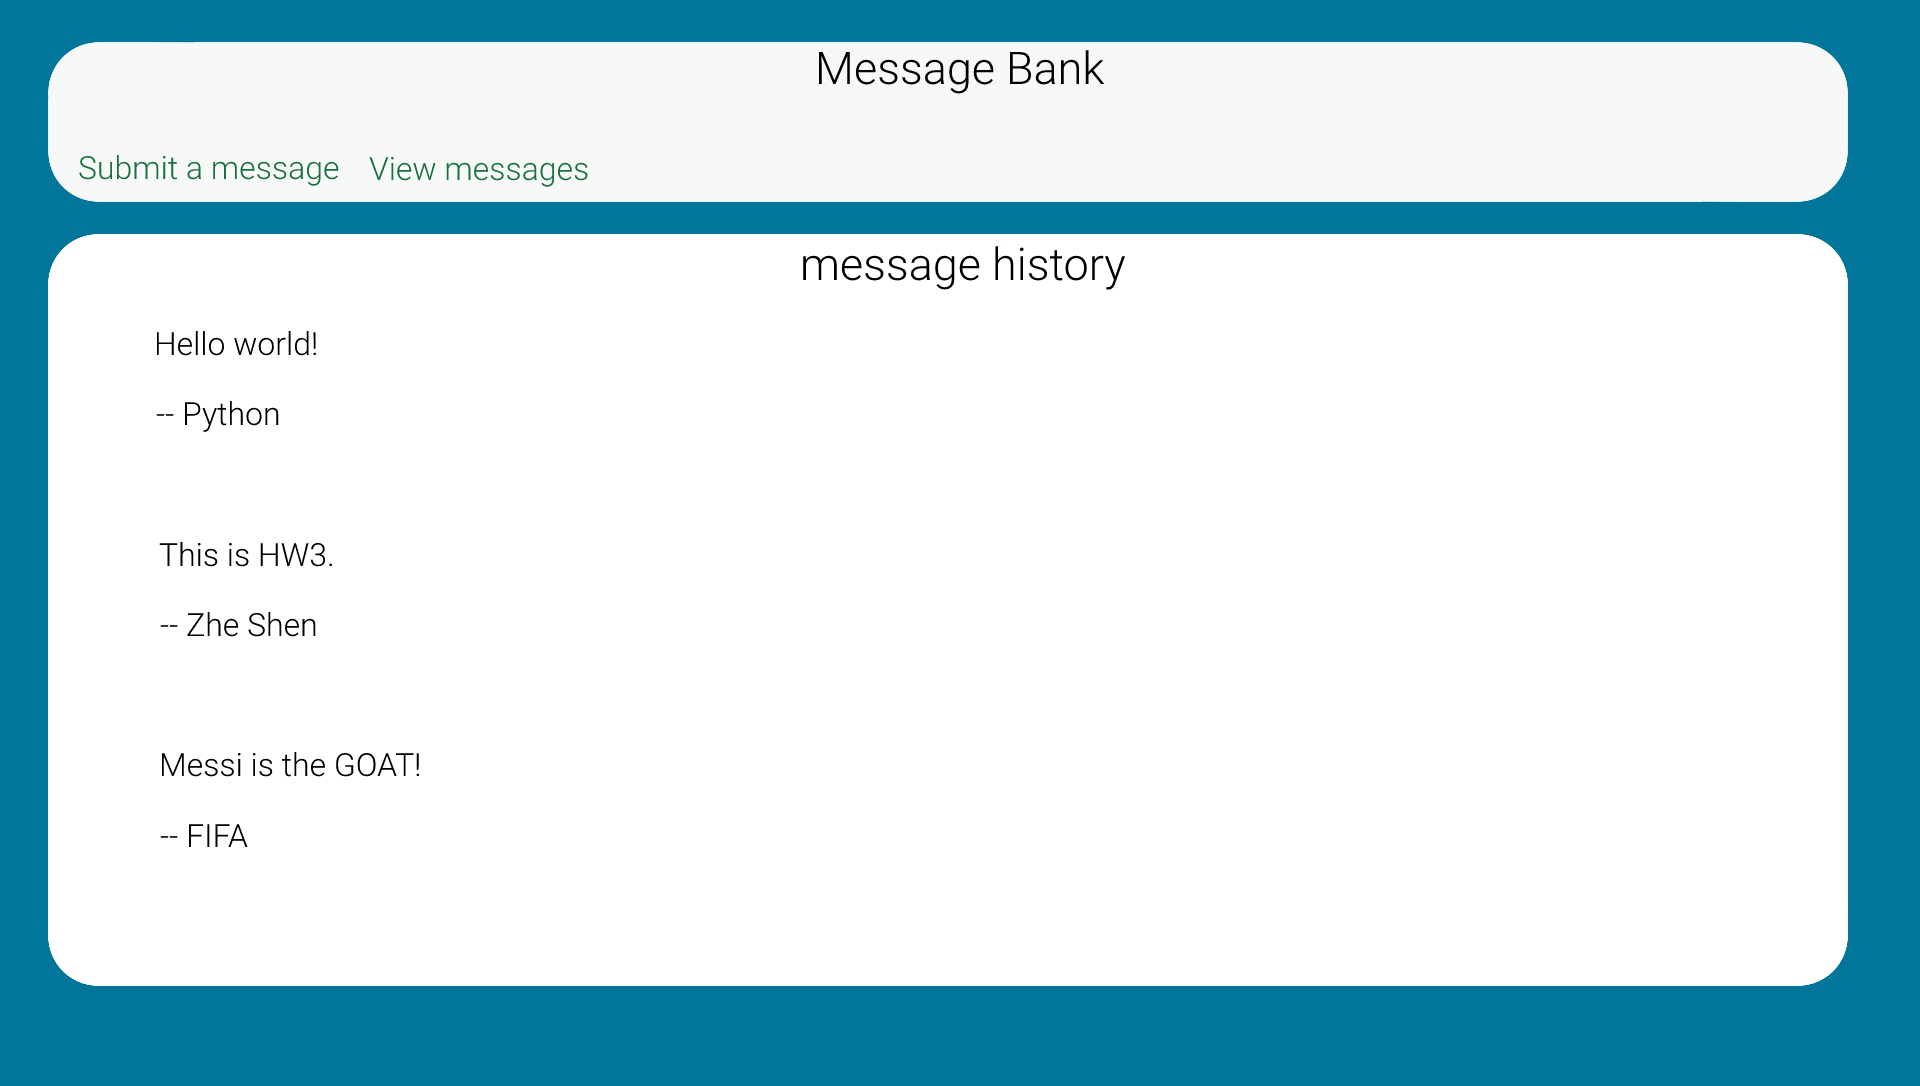